<a href="https://colab.research.google.com/github/HowardHNguyen/EDA/blob/main/EDA_Identifying_Outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outliers and unexpected values may not be errors. They often are not. Individuals and events are complicated and surprise the analyst. Some people really are 7’4” tall and some really have $50 million salaries. Sometimes, data is messy because people and situations are messy; however, extreme values can have an out-sized impact on our analysis, particularly when we are using parametric techniques that assume a normal distribution.

These issues may become even more apparent when working with subsets of data. That is not just because extreme or unexpected values have more weight with smaller samples. It is also because they may make less sense when bivariate and multivariate relationships are considered. When the 7’4” person, or the person making $50 million, is 10 years old, the red flag gets even redder. This may suggest some measurement or data collection error.

But the key issue is the undue influence that outliers can have on the inferences we draw from our data. Indeed, it may be helpful to think of an outlier as an observation with variable values, or relationships between variable values, that are so unusual that they cannot help to explain relationships in the rest of the data. This matters for statistical inference because we cannot assume a neutral impact of outliers on our summary statistics or parameter estimates. Sometimes our models work so hard to construct parameter estimates that can account for patterns in outlier observations that we compromise the model’s explanatory or predictive power for all other observations. Raise your hand if you have ever spent days trying to interpret a model only to discover that your coefficients and predictions completely changed once you removed a few outliers.

**Data note**

The NLS of Youth was conducted by the United States Bureau of Labor Statistics. This survey started with a cohort of individuals in 1997 who were born between 1980 and 1985, with annual follow-ups each year through to 2023. For this recipe, I pulled 89 variables on grades, employment, income, and attitudes toward government from the hundreds of data items in the survey. Separate files for SPSS, Stata, and SAS can be downloaded from the repository. The NLS data can be downloaded from https://www.nlsinfo.org. You must create an investigator account to download the data, but there is no charge.

Our World in Data provides COVID-19 public use data at https://ourworldindata.org/covid-cases. The dataset includes total cases and deaths, tests administered, hospital beds, and demographic data such as median age, gross domestic product, and a human development index, which is a composite measure of standard of living, educational levels, and life expectancy. The dataset used in this recipe was downloaded on March 3, 2024

## Identifying outliers with one variable

The concept of an outlier is somewhat subjective but is closely tied to the properties of a particular distribution; to its central tendency, spread, and shape. We make assumptions about whether a value is expected or unexpected based on how likely we are to get that value given the variable’s distribution. We are more inclined to view a value as an outlier if it is multiple standard deviations away from the mean and it is from a distribution that is approximately normal; one that is symmetrical (has low skew) and has relatively skinny tails (low kurtosis).

This becomes clear if we imagine trying to identify outliers from a uniform distribution. There is no central tendency and there are no tails. Each value is equally likely. If, for example, COVID-19 cases per country were uniformly distributed, with a minimum of 1 and a maximum of 10,000,000, neither 1 nor 10,000,000 would be considered an outlier.

We need to understand how a variable is distributed, then, before we can identify outliers. Several Python libraries provide tools to help us understand how variables of interest are distributed. We use a couple of them in this recipe to identify when a value is sufficiently out of range to be of concern.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as scistat
covidtotals = pd.read_csv("/content/drive/MyDrive/_Python/Python-Data-Cleaning/3. TakingMeasureOfData/data/covidtotals.csv")
covidtotals.set_index("iso_code", inplace=True)
totvars = ['location','total_cases','total_deaths','total_cases_pm','total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita','hosp_beds','hum_dev_ind']


In [4]:
covidtotals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, AFG to ZWE
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lastdate         231 non-null    object 
 1   location         231 non-null    object 
 2   total_cases      231 non-null    float64
 3   total_deaths     231 non-null    float64
 4   total_cases_pm   231 non-null    float64
 5   total_deaths_pm  231 non-null    float64
 6   population       231 non-null    int64  
 7   pop_density      209 non-null    float64
 8   median_age       194 non-null    float64
 9   gdp_per_capita   191 non-null    float64
 10  hosp_beds        170 non-null    float64
 11  vac_per_hund     13 non-null     float64
 12  aged_65_older    188 non-null    float64
 13  life_expectancy  227 non-null    float64
 14  hum_dev_ind      187 non-null    float64
 15  region           231 non-null    object 
dtypes: float64(12), int64(1), object(3)
memory usage: 38.8+ KB


In [5]:
# get descriptive statistics on the cumulative values
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,2.310000e+02,2.310000e+02,231.000000,231.000000
mean,3.351599e+06,3.021420e+04,206177.794623,1261.778390
std,1.148321e+07,1.047789e+05,203858.096252,1314.981529
min,4.000000e+00,0.000000e+00,354.487000,0.000000
25%,2.567150e+04,1.775000e+02,21821.863000,141.177000
50%,1.914960e+05,1.937000e+03,133946.251000,827.046000
75%,1.294286e+06,1.415000e+04,345689.831000,1997.513000
max,1.034368e+08,1.127152e+06,763475.441000,6507.656000


In [6]:
# Show more detailed percentile data. We indicate that we only want to do this for
# numeric values so that the location column is skipped:
covidtotalsonly.quantile(np.arange(0.0, 1.1, 0.1),numeric_only=True)

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,4.0,0.0,354.487,0.000
0.1,8359.0,31.0,3138.575,32.885
0.2,17181.0,126.0,10885.737,105.298
0.3,38008.0,294.0,35834.604,210.509
0.4,74129.0,844.0,86126.235,498.789
0.5,191496.0,1937.0,133946.251,827.046
0.6,472755.0,4384.0,220429.369,1251.299
0.7,1041111.0,9646.0,293737.443,1697.571
0.8,1877065.0,21218.0,416608.106,2271.676
0.9,5641992.0,62288.0,512388.401,3155.939


**Note**

Starting with pandas version 2.0.0, the default value for the numeric_only parameter is False for the quantile function. We needed to set the numeric_only value to True to get quantile to skip the location column.

We should also show skewness and kurtosis. Skewness and kurtosis describe how symmetrical the distribution is and how fat the tails of the distribution are, respectively. Both measures, for total_cases and total_deaths, are significantly higher than we would expect if our variables were distributed normally:

In [7]:
covidtotalsonly.skew(numeric_only=True)

,0
total_cases,6.307179
total_deaths,7.098945
total_cases_pm,0.834903
total_deaths_pm,1.252925


In [8]:
covidtotalsonly.kurtosis(numeric_only=True)

,0
total_cases,47.080248
total_deaths,61.727944
total_cases_pm,-0.428060
total_deaths_pm,1.256217


### Test the COVID-19 data for normality.
Use the Shapiro-Wilk test from the scipy library. Print out the p-value from the test (the null hypothesis of a normal distribution can be rejected at the 95% level at any p-value below 0.05):

In [9]:
def testnorm(var, df):
  stat, p = scistat.shapiro(df[var])
  return p
print("total cases: %.5f" % testnorm("total_cases", covidtotalsonly))
print("total deaths: %.5f" % testnorm("total_deaths", covidtotalsonly))
print("total cases pm: %.5f" % testnorm("total_cases_pm", covidtotalsonly))
print("total deaths pm: %.5f" % testnorm("total_deaths_pm", covidtotalsonly))

total cases: 0.00000
total deaths: 0.00000
total cases pm: 0.00000
total deaths pm: 0.00000


### Show normal quantile-quantile plots (qqplots) of total cases and total cases per million.
The straight lines show what the distributions would look like if they were normal:

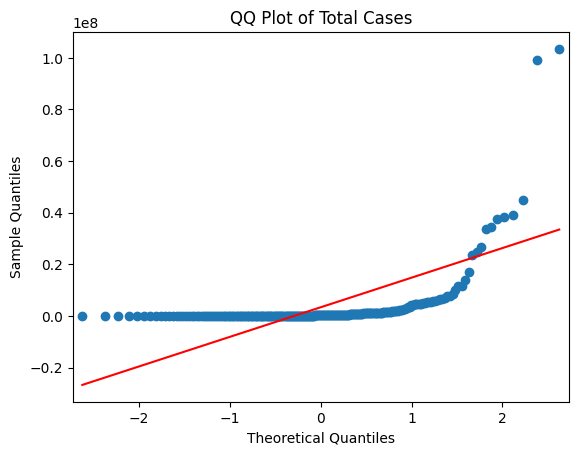

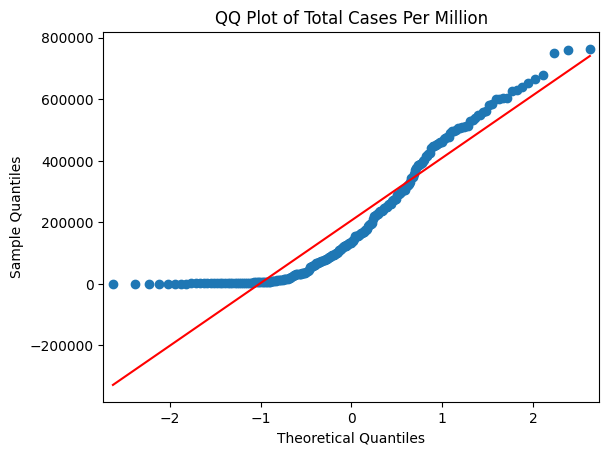

In [11]:
sm.qqplot(covidtotalsonly[['total_cases']].sort_values(['total_cases']), line='s')
plt.title("QQ Plot of Total Cases")
sm.qqplot(covidtotals[['total_cases_pm']].sort_values(['total_cases_pm']), line='s')
plt.title("QQ Plot of Total Cases Per Million")
plt.show()

- Figure 1 - Distribution of COVID-19 cases compared with a normal distribution
- When adjusted by population with the total cases per million column, the distribution is closer to normal:
- Figure 2 - Distribution of COVID-19 cases per million compared with a normal distribution

### Show the outlier range for total cases.
One way to define an outlier for a continuous variable is by the distance above the third quartile or below the first quartile. If that distance is more than 1.5 times the interquartile range (the distance between the first and third quartiles), that value is considered an outlier. The calculation in this step indicates that values above 3,197,208 can be considered outliers. In this case, we can ignore an outlier threshold that is less than 0, as that is not possible:

In [12]:
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquartilerange = 1.5*(thirdq-firstq)
outlierhigh, outlierlow = interquartilerange+thirdq, firstq-interquartilerange
print(outlierlow, outlierhigh, sep=" <--> ")

-1877250.25 <--> 3197207.75


### Generate a DataFrame of outliers and write it to Excel.
Iterate over the four COVID-19 case columns. Calculate the outlier thresholds for each column as we did in the previous step. From the DataFrame, select those rows above the high threshold or below the low threshold. Add columns that indicate the variable examined (varname) for outliers and the threshold levels:

In [13]:
# generate a table of outliers and save it to Excel
def getoutliers():
  dfout = pd.DataFrame(columns=covidtotals. \
    columns, data=None)
  for col in covidtotalsonly.columns[1:]:
    thirdq, firstq = covidtotalsonly[col].\
      quantile(0.75),covidtotalsonly[col].\
      quantile(0.25)
    interquartilerange = 1.5*(thirdq-firstq)
    outlierhigh, outlierlow = \
      interquartilerange+thirdq, \
      firstq-interquartilerange
    df = covidtotals.loc[(covidtotals[col]> \
      outlierhigh) | (covidtotals[col]< \
      outlierlow)]
    df = df.assign(varname = col,
      threshlow = outlierlow,
      threshhigh = outlierhigh)
    dfout = pd.concat([dfout, df])
  return dfout

In [14]:
outliers = getoutliers()
outliers.varname.value_counts()

<ipython-input-13-258503b5d1ac>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfout = pd.concat([dfout, df])


,count
varname,
total_cases,39
total_deaths,33
total_deaths_pm,4


There were 39 countries identified as outliers in the total_deaths values according to the interquartile method, and 33 total_cases outliers. Notice that there were no outliers for total _cases_pm.

In [15]:
# export to excel file
outliers.to_excel("/content/drive/MyDrive/_Python/Python-Data-Cleaning/3. TakingMeasureOfData/views/covid_outliers_cases.xlsx")

### Look a little more closely at outliers for total deaths per million.
Use the varname column we created in the previous step to select the outliers for total_deaths_pm. Show the columns (median_age and hum_dev_ind) that might help to explain the extreme values for those columns. We also show the 25th, 50th, and 75th percentile for those columns for the whole dataset for comparison:

In [16]:
outliers.loc[outliers.varname=="total_deaths_pm",
  ['location','total_deaths_pm','total_cases_pm',
   'median_age','hum_dev_ind']].sort_values(['total_deaths_pm'], ascending=False)

,location,total_deaths_pm,total_cases_pm,median_age,hum_dev_ind
PER,Peru,6507.656,133238.998,29.1,0.777
BGR,Bulgaria,5703.518,195767.887,44.7,0.816
BIH,Bosnia and Herzegovina,5066.290,124806.326,42.5,0.780
HUN,Hungary,4918.281,223685.161,43.4,0.854


In [17]:
covidtotals[['total_deaths_pm','median_age',
  'hum_dev_ind']]. quantile([0.25,0.5,0.75])

,total_deaths_pm,median_age,hum_dev_ind
0.25,141.177,22.05,0.6015
0.50,827.046,29.60,0.7400
0.75,1997.513,38.70,0.8285


All four countries are well beyond the 75th percentile for deaths per million. Three of the four countries are near or above the 75th percentile for both median age and the human development index. Surprisingly, there is a positive correlation between the human development index and deaths per million. We display a correlation matrix in the next recipe.

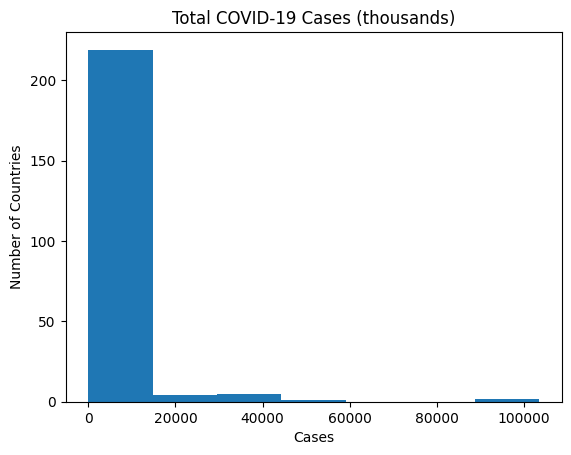

In [18]:
# Show a histogram of total cases:
plt.hist(covidtotalsonly['total_cases']/1000, bins=7)
plt.title("Total COVID-19 Cases (thousands)")
plt.xlabel('Cases')
plt.ylabel("Number of Countries")
plt.show()

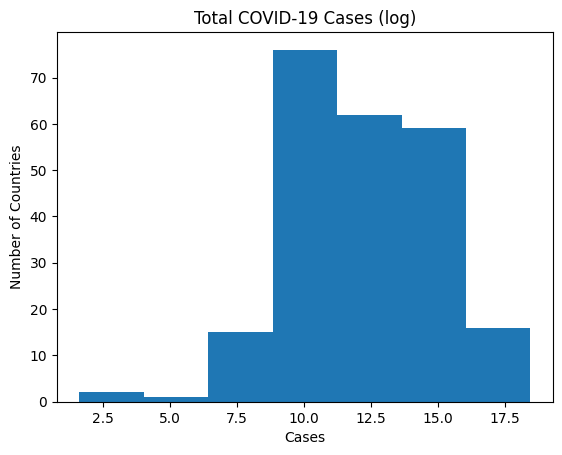

In [19]:
# Perform a log transformation of the COVID-19 data. Show a histogram of the log transformation of total cases:
covidlogs = covidtotalsonly.copy()
for col in covidlogs.columns[1:]:covidlogs[col] = np.log1p(covidlogs[col])
plt.hist(covidlogs['total_cases'], bins=7)
plt.title("Total COVID-19 Cases (log)")
plt.xlabel('Cases')
plt.ylabel("Number of Countries")
plt.show()

Histogram of total COVID-19 cases with log transformation

## Using Isolation Forest to find anomalies

Isolation Forest is a relatively new machine learning technique for identifying anomalies. It has quickly become popular, partly because its algorithm is optimized to find anomalies, rather than normal values. It finds outliers by successive partitioning of the data until a data point has been isolated. Points that require fewer partitions to be isolated receive higher anomaly scores. This process turns out to be fairly easy on system resources. In this recipe, we demonstrate how to use it to detect outlier COVID-19 cases and deaths.

Getting ready
You will need scikit-learn and Matplotlib to run the code in this recipe. You can install them by entering pip install sklearn and pip install matplotlib in the terminal or PowerShell (in Windows).

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
# covidtotals = pd.read_csv("data/covidtotals.csv") # loaded
# covidtotals.set_index("iso_code", inplace=True)

### Create a standardized analysis DataFrame.
First, remove all rows with missing data:

In [22]:
analysisvars = ['location','total_cases_pm','total_deaths_pm','pop_density','median_age','gdp_per_capita']
standardizer = StandardScaler()
covidtotals.isnull().sum()

,0
lastdate,0
location,0
total_cases,0
total_deaths,0
total_cases_pm,0
total_deaths_pm,0
population,0
pop_density,22
median_age,37
gdp_per_capita,40


In [23]:
covidanalysis = covidtotals.loc[:, analysisvars].dropna()
covidanalysisstand = standardizer.fit_transform(covidanalysis.iloc[:, 1:])

### Run an Isolation Forest model to detect outliers.
Pass the standardized data to the fit method. 18 countries are identified as outliers. (These countries have anomaly values of -1.) This is determined by the contamination number of 0.1:

In [24]:
clf=IsolationForest(n_estimators=100,
  max_samples='auto', contamination=.1,
  max_features=1.0)
clf.fit(covidanalysisstand)

IsolationForest(contamination=0.1)

In [25]:
IsolationForest(contamination=0.1)

IsolationForest(contamination=0.1)

In [26]:
covidanalysis['anomaly'] = clf.predict(covidanalysisstand)
covidanalysis['scores'] = clf.decision_function(covidanalysisstand)
covidanalysis.anomaly.value_counts()

,count
anomaly,
1,162
-1,18


### Create outlier and inlier DataFrames.
List the top 10 outliers according to anomaly score:

In [27]:
inlier, outlier = covidanalysis.loc[covidanalysis.anomaly==1],covidanalysis.loc[covidanalysis.anomaly==-1]
outlier[['location','total_cases_pm',
  'total_deaths_pm','median_age',
  'gdp_per_capita','scores']].sort_values(['scores']).head(10)

,location,total_cases_pm,total_deaths_pm,median_age,gdp_per_capita,scores
iso_code,,,,,,
SGP,Singapore,531183.841,346.637,42.4,85535.383,-0.265346
QAT,Qatar,190908.716,256.017,31.9,116935.600,-0.108455
LUX,Luxembourg,603439.463,1544.161,39.7,94277.965,-0.100428
BRN,Brunei,763475.441,396.435,32.4,71809.251,-0.093915
BHR,Bahrain,473167.024,1043.310,32.4,43290.705,-0.093772
PER,Peru,133238.998,6507.656,29.1,12236.706,-0.090976
MLT,Malta,227422.824,1687.628,42.4,36513.323,-0.066482
KOR,South Korea,667207.062,693.495,43.4,35938.374,-0.048059
BGR,Bulgaria,195767.887,5703.518,44.7,18563.307,-0.047703


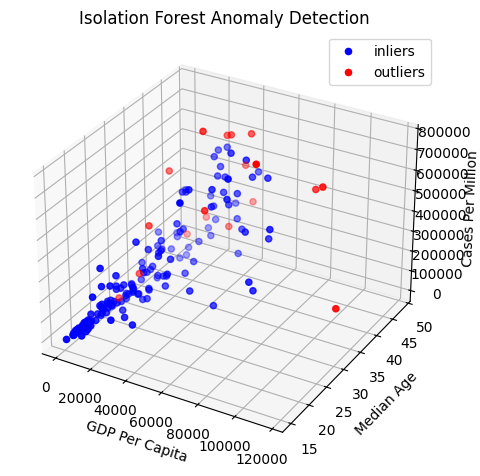

In [28]:
# plot the outliers and inliers
ax = plt.axes(projection='3d')
ax.set_title('Isolation Forest Anomaly Detection')
ax.set_zlabel("Cases Per Million")
ax.set_xlabel("GDP Per Capita")
ax.set_ylabel("Median Age")
ax.scatter3D(inlier.gdp_per_capita, inlier.median_age, inlier.total_cases_pm, label="inliers", c="blue")
ax.scatter3D(outlier.gdp_per_capita, outlier.median_age, outlier.total_cases_pm, label="outliers", c="red")
ax.legend()
plt.tight_layout()
plt.show()

Inlier and outlier countries by GDP, median age, and cases per million

In [29]:
import plotly.graph_objects as go

# Create a 3D scatter plot
fig = go.Figure()

# Add inliers as blue points
fig.add_trace(go.Scatter3d(
    x=inlier.gdp_per_capita,
    y=inlier.median_age,
    z=inlier.total_cases_pm,
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.8),
    name='Inliers'
))

# Add outliers as red points
fig.add_trace(go.Scatter3d(
    x=outlier.gdp_per_capita,
    y=outlier.median_age,
    z=outlier.total_cases_pm,
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8),
    name='Outliers'
))

# Set plot title and axis labels
fig.update_layout(
    title='Isolation Forest Anomaly Detection (Interactive)',
    scene=dict(
        xaxis_title='GDP Per Capita',
        yaxis_title='Median Age',
        zaxis_title='Cases Per Million'
    ),
    legend=dict(x=0.1, y=0.9),
    margin=dict(l=0, r=0, b=0, t=40)  # Adjust margins for better visibility
)

# Show the interactive plot
fig.show()